In [1]:
# !pip install LTNtorch
# !pip install graphviz

### See here for more tutorials: https://github.com/tommasocarraro/LTNtorch


In [2]:
!pwd

/home/p/Documents/code/ltn


In [3]:
import torch
import ltn
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Functions

In [4]:
# we define predicate A
#       "init" method = defines layers / sigmoid / relu / dropout
#       "forward" method = combines the layers and activations into a model architecture

class ModelA(torch.nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.sigmoid = torch.nn.Sigmoid()

        self.layer1 = torch.nn.Linear(11, 64)
        self.layer2 = torch.nn.Linear(64, 64)
        self.layer3 = torch.nn.Linear(64, 1)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.1)
        

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        return self.sigmoid(self.layer3(x))

In [5]:
# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
#      "init" method = initialise data / labels / batch_size / shuffle
#      "__len" method  = number of batches i.e. shape[0] / batch_size 
#      "__iter__" GENERATOR method == 'n' = number of samples in the shape[0] direction.
#                           'idx_pos' = array of positive indices
#                           'idx_neg' = array of negative indices
#                 YIELDS a batch of data and labels - obviously generator approach is preferred.

class DataLoader(object):
    def __init__(self, data, labels, batch_size=1, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idx_pos = np.where(self.labels == 1)[0]
        idx_neg = np.where(self.labels == 0)[0]
        np.random.shuffle(idx_pos)
        np.random.shuffle(idx_neg)

        for start_idx in range(0, n, self.batch_size):
            end_idx = min(start_idx + self.batch_size, n)

            # Get one positive and one negative sample for each batch
            pos_batch_size = min(self.batch_size // 2, len(idx_pos))
            neg_batch_size = self.batch_size - pos_batch_size
            pos_idx = idx_pos[:pos_batch_size]
            neg_idx = np.random.choice(idx_neg, size=neg_batch_size, replace=False)
            idx = np.concatenate([pos_idx, neg_idx])
            np.random.shuffle(idx)

            data = self.data[idx]
            labels = self.labels[idx]

            yield data, labels


# define metrics for evaluation of the model

# it computes the overall satisfaction level on the knowledge base using the given data loader (train or test)
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        # get our positive samples
        x_A = ltn.Variable("x_A", data[torch.nonzero(labels)])
        # get our negative samples
        x_not_A = ltn.Variable("x_not_A",
                               data[torch.nonzero(torch.logical_not(labels))])
        
        # get the mean SAT of both sample types
        mean_sat += SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )
    
    # get the mean SAT over all samples
    mean_sat /= len(loader)
    return mean_sat

# it computes the overall accuracy of the predictions of the trained model using the given data loader
# (train or test)
def compute_accuracy(loader):
    mean_accuracy = 0.0
    # iterate over our data samples
    for data, labels in loader:
        # get the predictions for the given samples
        predictions = A.model(data).detach().numpy()

        # convert the predictions to a binary classification (i.e., 0 or 1)
        predictions = np.where(predictions > 0.5, 1., 0.).flatten()

        # compute the accuracy_score
        mean_accuracy += accuracy_score(labels, predictions)
    # get the mean accuracy
    return mean_accuracy / len(loader)


# it computes the overall accuracy of the predictions of the trained model using the given data loader
# (train or test)
def compute_f1(loader):
    mean_accuracy = 0.0
    # iterate over our data samples
    for data, labels in loader:
        # get the predictions for the given samples
        predictions = A.model(data).detach().numpy()

        # convert the predictions to a binary classification (i.e., 0 or 1)
        predictions = np.where(predictions > 0.5, 1., 0.).flatten()

        # compute the accuracy_score
        mean_accuracy += f1_score(labels, predictions)
    # get the mean accuracy
    return mean_accuracy / len(loader)

# Data - create Standard Normal Distribution of features
## and convert outcome into True / False

In [6]:
import pandas as pd
import numpy as np 
import torch

df = pd.read_csv('wine_dataset.csv')
print(f"\nNumber of columns = {len(df.columns)}\n")
print(f"Columns = \n{df.columns}")
print(f"\n\nDescribe:\n{df.describe}")

df.drop('quality', axis=1, inplace=True)

df['style'] = np.where(df['style'] == 'red', True, False)
print(f"\n\nDescribe 'style' after change to True / False :\n{df['style'].describe}")

print(f"\nLen df before sampling = {len(df)}")
df = df.sample(frac=1)     # Return a random sample of items from an axis of object. Frac =1 implies 100% sample...
print(f"\nLen df after sampling = {len(df)}")

features = df.drop('style', axis=1).values
print(f"\nShape of features = {features.shape}")

print(f"\nType of features = {type(features)}")
print(f"\n\nNumber of unique features = {len(np.unique(features))}\n")
print(f"\n\nTotal number of features = {len(features)}\n")
print(f"\n\nMin feature = {np.min(features)}; Max feature = {np.max(features)}\n")

# Standard normal distribution of all 11 features:
features = (features - features.mean()) / features.std()
features = torch.tensor(features).to(dtype=torch.float32)
labels = torch.tensor(df['style'].values).to(dtype=torch.float32)


Number of columns = 13

Columns = 
Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'style'],
      dtype='object')


Describe:
<bound method NDFrame.describe of       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.

# Modelling
## ltn.Predicate gets passed the Neural Network model as input
### An LTN connective is grounded as a fuzzy connective operator.
### An LTN quantifier is grounded as a fuzzy aggregation operator. 

In [7]:
A = ltn.Predicate(ModelA())

# we define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

# create training and testing dataloader, batch_size = 64
train_loader = DataLoader(features[:91], labels[:91], 64, True)
test_loader = DataLoader(features[91:], labels[91:], 64, False)

optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

In [8]:
EPOCHS: int = 100
train_sat_list, test_sat_list, train_acc_list, test_acc_list, epoch_list = [], [], [], [], []

for epoch in range(EPOCHS):
    # reset the training loss for every epoch
    train_loss = 0.0

    # start batching the data
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[torch.nonzero(labels)]) # positive examples
        x_not_A = ltn.Variable("x_not_A", data[torch.nonzero(torch.logical_not(labels))]) # negative examples

        # compute SAT level
        sat_agg = SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )

        # compute loss and perform back-propagation
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # monitor the training loss
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        train_sat = compute_sat_level(train_loader).item()
        test_sat = compute_sat_level(test_loader).item()
        train_acc = compute_accuracy(train_loader)
        test_acc = compute_accuracy(test_loader)

        epoch_list.append(epoch)
        train_sat_list.append(train_sat)
        test_sat_list.append(test_sat)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f | Train F1 %.3f | Test F1 %.3f"
              %(epoch, train_loss, train_sat, test_sat, train_acc, test_acc, compute_f1(train_loader), compute_f1(test_loader)))

 epoch 0 | loss 0.4917 | Train Sat 0.514 | Test Sat 0.515 | Train Acc 0.680 | Test Acc 0.524 | Train F1 0.087 | Test F1 0.060
 epoch 20 | loss 0.3559 | Train Sat 0.646 | Test Sat 0.632 | Train Acc 0.891 | Test Acc 0.903 | Train F1 0.829 | Test F1 0.909
 epoch 40 | loss 0.2922 | Train Sat 0.709 | Test Sat 0.719 | Train Acc 0.906 | Test Acc 0.874 | Train F1 0.837 | Test F1 0.875
 epoch 60 | loss 0.2933 | Train Sat 0.718 | Test Sat 0.679 | Train Acc 0.875 | Test Acc 0.907 | Train F1 0.837 | Test F1 0.857
 epoch 80 | loss 0.2837 | Train Sat 0.718 | Test Sat 0.709 | Train Acc 0.891 | Test Acc 0.920 | Train F1 0.800 | Test F1 0.870


# Plots:

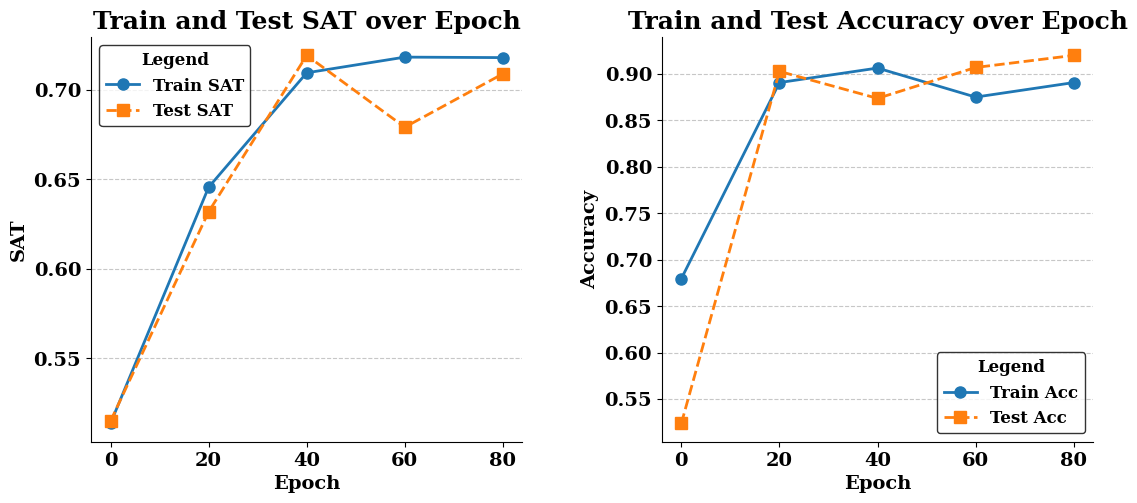

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

font = {'family': 'serif', 'weight': 'bold', 'size': 14}
plt.rc('font', **font)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


# Plot 1: Train and Test SAT over Epoch
axs[0].plot(epoch_list, train_sat_list, label='Train SAT', linewidth=2, linestyle='-', marker='o', markersize=8, color='#1f77b4')
axs[0].plot(epoch_list, test_sat_list, label='Test SAT', linewidth=2, linestyle='--', marker='s', markersize=8, color='#ff7f0e')
axs[0].set_xlabel('Epoch', fontsize=14, fontweight='bold', fontfamily='serif')
axs[0].set_ylabel('SAT', fontsize=14, fontweight='bold', fontfamily='serif')
axs[0].set_title('Train and Test SAT over Epoch', fontsize=18, fontweight='bold', fontfamily='serif')
axs[0].legend(loc='best', fontsize=12, framealpha=0.8, title_fontsize=12, title='Legend', edgecolor='black')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Plot 2: Train and Test Accuracy over Epoch
axs[1].plot(epoch_list, train_acc_list, label='Train Acc', linewidth=2, linestyle='-', marker='o', markersize=8, color='#1f77b4')
axs[1].plot(epoch_list, test_acc_list, label='Test Acc', linewidth=2, linestyle='--', marker='s', markersize=8, color='#ff7f0e')
axs[1].set_xlabel('Epoch', fontsize=14, fontweight='bold', fontfamily='serif')
axs[1].set_ylabel('Accuracy', fontsize=14, fontweight='bold', fontfamily='serif')
axs[1].set_title('Train and Test Accuracy over Epoch', fontsize=18, fontweight='bold', fontfamily='serif')
axs[1].legend(loc='best', fontsize=12, framealpha=0.8, title_fontsize=12, title='Legend', edgecolor='black')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Adjust spacing between subplots
fig.tight_layout(pad=3.0)

plt.show()



---



---



In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

In [11]:
df = pd.read_csv('wine_dataset.csv')
df.drop('quality', axis=1, inplace=True)
df['style'] = np.where(df['style'] == 'red', True, False)

df = df.sample(frac=1)

features = df.drop('style', axis=1)
features = (features - features.mean()) / features.std()
labels = df['style']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [13]:
dt = DecisionTreeClassifier(random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(64,), max_iter=1000, random_state=42)

In [14]:
estimators = [('dt', dt), ('nn', nn)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=nn)

In [15]:
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                               ('nn',
                                MLPClassifier(hidden_layer_sizes=(64,),
                                              max_iter=1000,
                                              random_state=42))],
                   final_estimator=MLPClassifier(hidden_layer_sizes=(64,),
                                                 max_iter=1000,
                                                 random_state=42))

In [16]:
print(f"Accuracy: {stacking_clf.score(X_test, y_test):.3f}")

Accuracy: 0.999


In [17]:
from sklearn.tree import export_text

# Get the decision tree classifier from the stacking classifier
dt_clf = stacking_clf.estimators_[0]

# Convert the decision tree to rules using export_text
tree_rules = export_text(dt_clf, feature_names=X_train.columns.tolist())

# Parse the text representation of the rules to create a list of rules
rule_list = [rule.strip() for rule in tree_rules.split('\n') if rule.strip()]

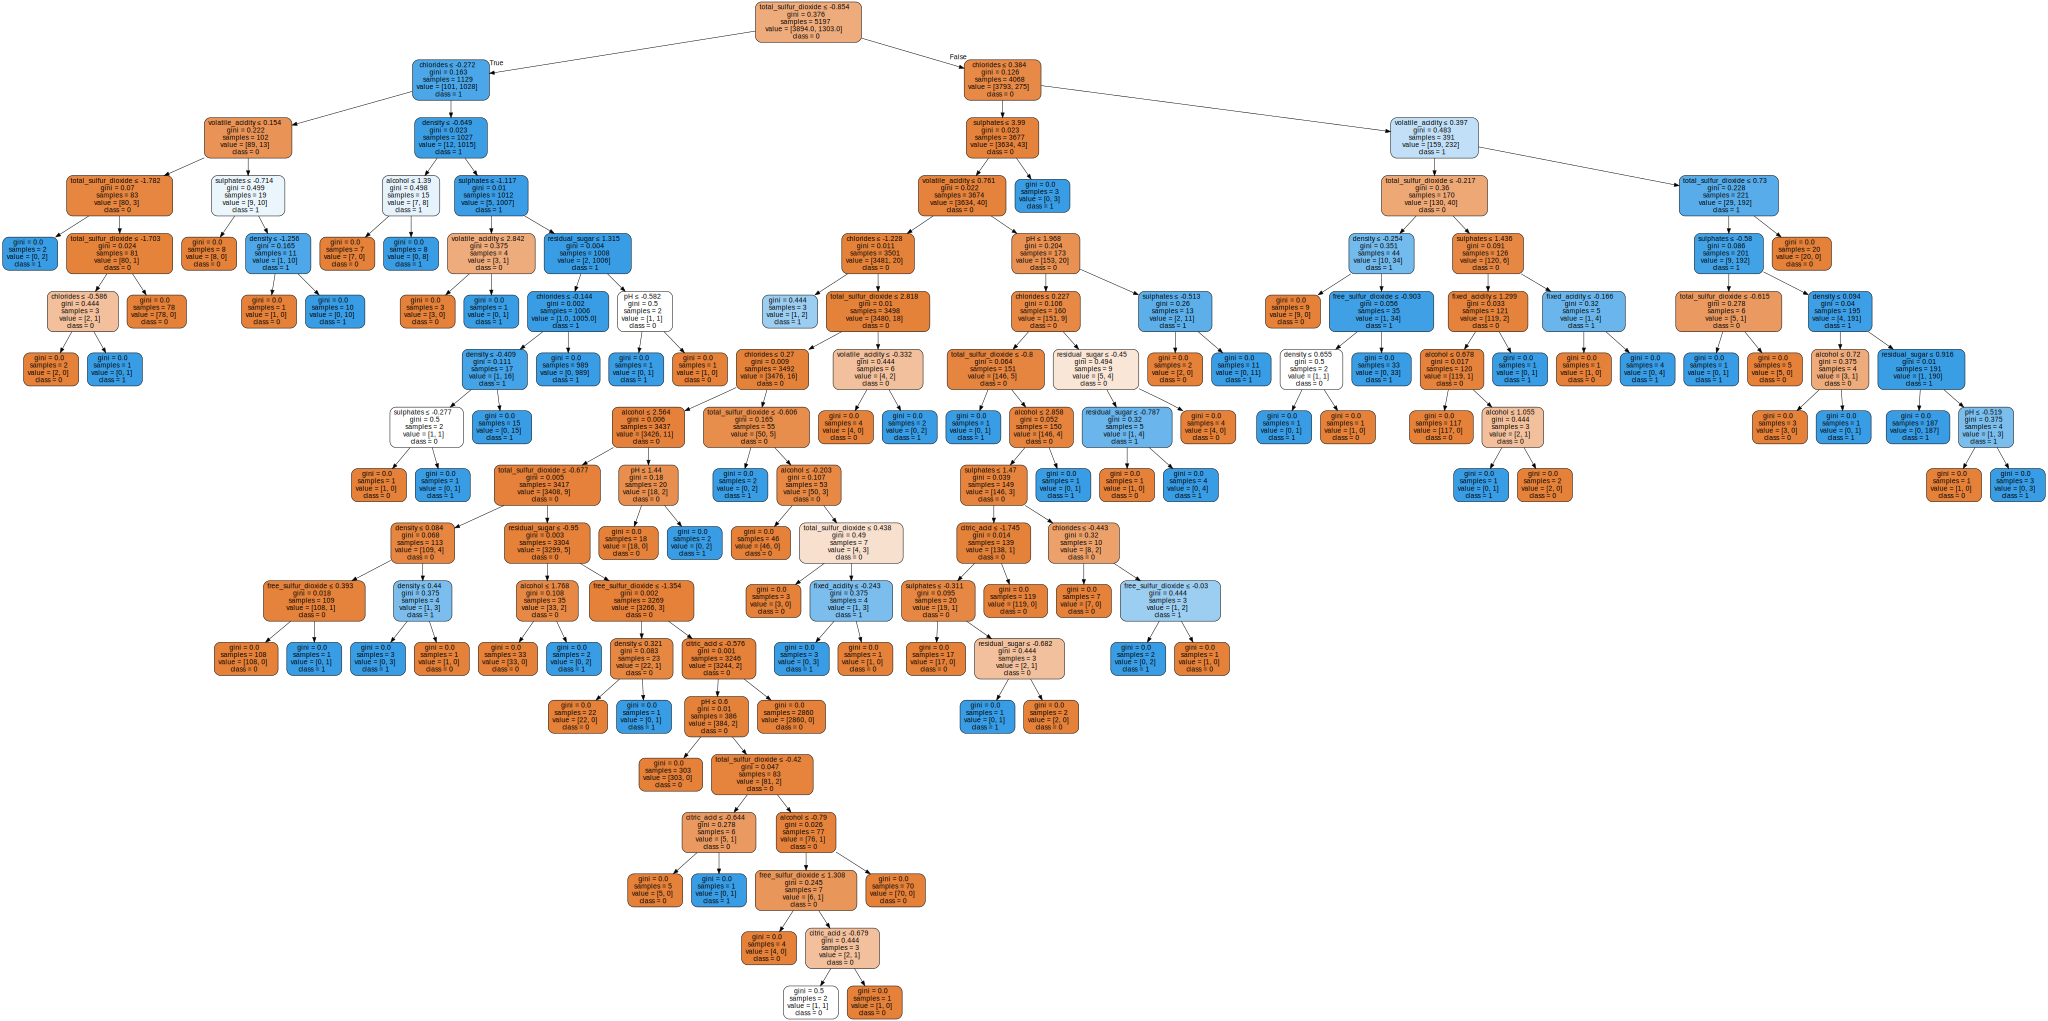

In [18]:
from sklearn.tree import export_graphviz
import graphviz

#  You should install the graphviz package in your system (not just the python package). On Ubuntu you should try:
#  sudo apt-get install graphviz

# Export the decision tree as a Graphviz file
dot_data = export_graphviz(dt_clf, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['0', '1'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)

# Show the decision tree
graph
